## Project: Unsupervised Learning
----------------------------------------
**Marks: 30**
-----------------------------------------

Welcome to the project on Unsupervised Learning. We will be using the Credit Card Customer Data for this project.

----------------------------
## Context: 
-----------------------------
AllLife Bank wants to focus on its credit card customer base in the next financial year. They have been advised by their marketing research team, that the penetration in the market can be improved. Based on this input, the Marketing team proposes to run personalized campaigns to target new customers as well as upsell to existing customers. Another insight from the market research was that the customers perceive the support services of the back poorly. Based on this, the Operations team wants to upgrade the service delivery model, to ensure that customers queries are resolved faster. Head of Marketing and Head of Delivery both decide to reach out to the Data Science team for help.


----------------------------
## Objective: 
-----------------------------

Identify different segments in the existing customer based on their spending patterns as well as past interaction with the bank.

--------------------------
## About the data:
--------------------------
Data is of various customers of a bank with their credit limit, the total number of credit cards the customer has, and different channels through which customer has contacted the bank for any queries, different channels include visiting the bank, online and through a call centre.

- Sl_no - Customer Serial Number
- Customer Key - Customer identification
- Avg_Credit_Limit	- Average credit limit (currency is not specified, you can make an assumption around this)
- Total_Credit_Cards	- Total number of credit cards 
- Total_visits_bank	- Total bank visits
- Total_visits_online -	 Total online visits
- Total_calls_made - Total calls made

## Importing libraries and overview of the dataset

In [2]:
#Import all the necessary packages

import pandas as pd
import numpy as np

import matplotlib.pylab as plt
import seaborn as sns

#to scale the data using z-score 
from sklearn.preprocessing import StandardScaler

#importing clustering algorithms
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture


#if the below line of code gives an error, then uncomment the following code to install the sklearn_extra library
!pip install scikit-learn-extra
from sklearn_extra.cluster import KMedoids

import warnings
warnings.filterwarnings("ignore")

     |████████████████████████████████| 1.7 MB 37.2 MB/s 
     |████████████████████████████████| 23.2 MB 2.0 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


#### Loading data

In [43]:
data = pd.read_excel('Credit Card Customer Data.xlsx')
data.head()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


#### Check the info of the data

In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


**Observations:**

- There are 660 observations and 7 columns in the dataset.
- All columns have 660 non-null values i.e. there are no missing values.
- All columns are of int64 data type.

**There are no missing values. Let us now figure out the uniques in each column.** 

In [23]:
data.nunique()

Sl_No                  660
Customer Key           655
Avg_Credit_Limit       110
Total_Credit_Cards      10
Total_visits_bank        6
Total_visits_online     16
Total_calls_made        11
dtype: int64

- Customer key, which is an identifier, has repeated values. We should treat the same accordingly before applying any algorithm.

## Data Preprocessing and Exploratory Data Analysis

#### **Question 1: Identify and drop the rows with duplicated customer keys (2 Marks)**

In [44]:
# Identify the duplicated customer keys
duplicate_keys = data.duplicated(subset=['Customer Key'])
duplicate_keys.value_counts()

False    655
True       5
dtype: int64

In [45]:
# Drop duplicated keys

data=data[~data.duplicated(subset=['Customer Key'])]
data.shape

(655, 7)

We have done some basic checks. Now, let's drop the variables that are not required for our analysis.

In [46]:
data.drop(columns = ['Sl_No', 'Customer Key'], inplace = True)

Now that we have dropped unnecessary column. We can again check for duplicates. Duplicates would mean customers with identical features.

In [47]:
data[data.duplicated()]

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
162,8000,2,0,3,4
175,6000,1,0,2,5
215,8000,4,0,4,7
295,10000,6,4,2,3
324,9000,4,5,0,4
361,18000,6,3,1,4
378,12000,6,5,2,1
385,8000,7,4,2,0
395,5000,4,5,0,1
455,47000,6,2,0,4


We can drop these duplicated rows from the data

In [48]:
data=data[~data.duplicated()]

In [49]:
data.shape

(644, 5)

- After removing duplicated keys and rows and unnecessary columns, there are 644 unique observations and 5 columns in our data.

#### Summary Statistics

#### **Question 2: Write your observations on the summary statistics of the data (1 Mark)**

In [ ]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Avg_Credit_Limit,644.0,34543.478261,37428.704286,3000.0,11000.0,18000.0,48000.00,200000.0
Total_Credit_Cards,644.0,4.694099,2.175338,1.0,3.0,5.0,6.00,10.0
Total_visits_bank,644.0,2.395963,1.626964,0.0,1.0,2.0,4.00,5.0
Total_visits_online,644.0,2.624224,2.957728,0.0,1.0,2.0,4.00,15.0
Total_calls_made,644.0,3.608696,2.880025,0.0,1.0,3.0,5.25,10.0


**Observations:**

- The variable Avg Credit Limit seems to have significant outliers on the higher side, based on comparing the mean and median as well as the max with the upper whisker (75th percentile + 1.5x IQR).  Similarly, Total Visits Online seems to have large outliers on the high side.   
- The mean is greater than the median for all variables except Total Credit Cards, indicating a positive skew for those variables.   

#### Now let's go ahead with the exploring each variable at hand. We will check the distribution and outliers for each variable in the data.

#### Question 3:
- **Check the distribution of all variables (use .hist() attribute) (2 Marks)**
- **Check outliers for all variables (use sns.boxplot()) (2 Mark)**
- **Write your observations (1 Marks)**

Avg_Credit_Limit
Skew : 2.19


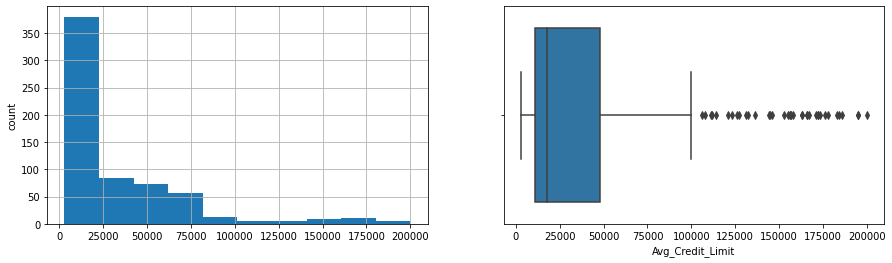

Total_Credit_Cards
Skew : 0.17


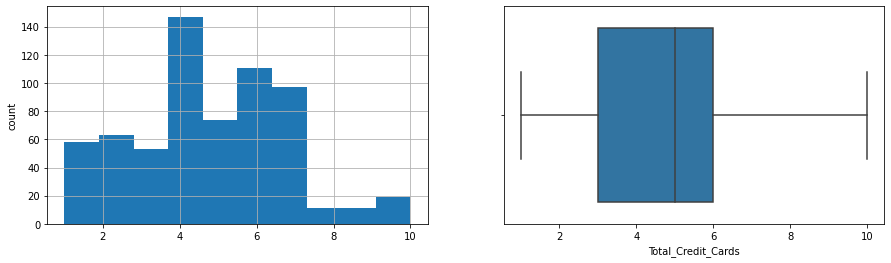

Total_visits_bank
Skew : 0.15


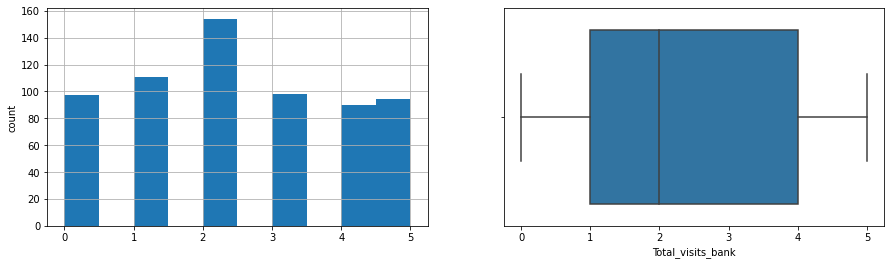

Total_visits_online
Skew : 2.21


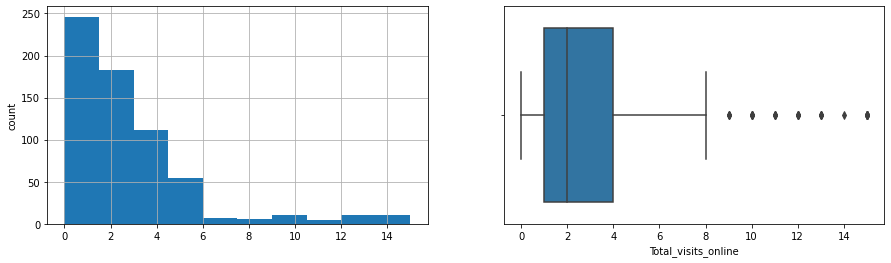

Total_calls_made
Skew : 0.65


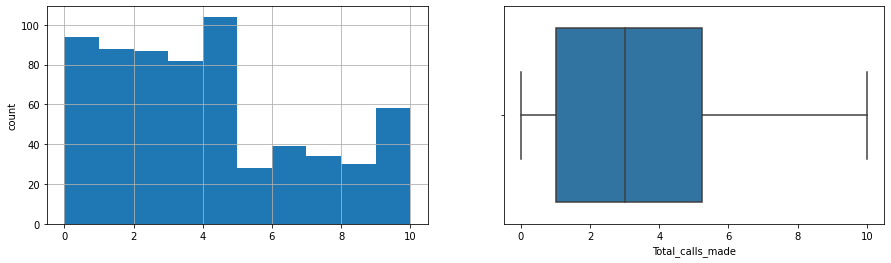

In [51]:
# Uncomment and complete the code by filling the blanks 

for col in data.columns:
    print(col)
    print('Skew :',round(data[col].skew(),2))
    plt.figure(figsize=(15,4))
    plt.subplot(1,2,1)
    data[col].hist()
    plt.ylabel('count')
    plt.subplot(1,2,2)
    sns.boxplot(x=data[col])
    plt.show()

**Observation:**
- The variables Average Credit Limit and Total Visits Online have a large number of outliers on the higher end and a large positive skew.  
- The categorical variables (Total Credit Cards, Total Visits Bank, Total Visits Online, and Total Calls Made) are quite imbalanced. 
- The variables Total Credit Cards and Total Visits Bank have close to zero, but positive skew.  

**Now, let's check the correlation among different variables.**

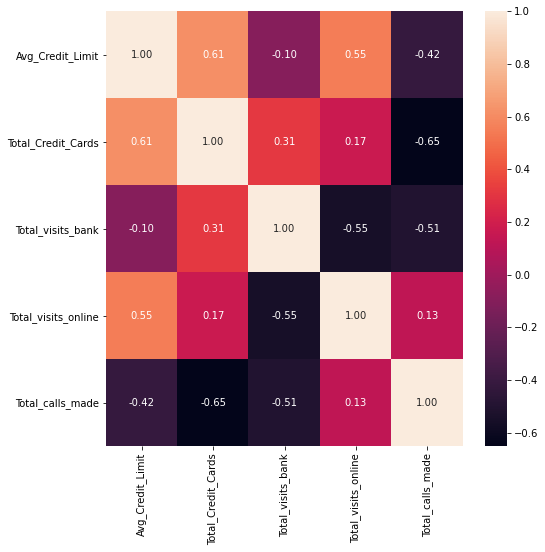

In [ ]:
plt.figure(figsize=(8,8))
sns.heatmap(data.corr(), annot=True, fmt='0.2f')
plt.show()

**Observation:**

- Avg_Credit_Limit is positively correlated with Total_Credit_Cards Total_visits_online which can makes sense.
- Avg_Credit_Limit is negatively correlated with Total_calls_made and Total_visits_bank.
- Total_visits_bank, Total_visits_online, Total_calls_made are negatively correlated which implies that majority of customers use only one of these channels to contact the bank.

#### Scaling the data

In [52]:
scaler=StandardScaler()
data_scaled=pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

In [53]:
data_scaled.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1.750192,-1.239437,-0.858684,-0.549573,-1.253982
1,0.413280,-0.779381,-1.473803,2.495669,1.873420
2,0.413280,1.060843,-0.858684,0.127148,0.135974
3,-0.121485,0.140731,-0.858684,-0.549573,0.135974
4,1.750192,0.600787,-1.473803,3.172390,-0.211515


In [54]:
#Creating copy of the data to store labels from each algorithm
data_scaled_copy = data_scaled.copy(deep=True)

## K-Means

Let us now fit k-means algorithm on our scaled data and find out the optimum number of clusters to use.

We will do this in 3 steps:
1. Initialize a dictionary to store the SSE for each k
2. Run for a range of Ks and store SSE for each run
3. Plot the SSE vs K and find the elbow

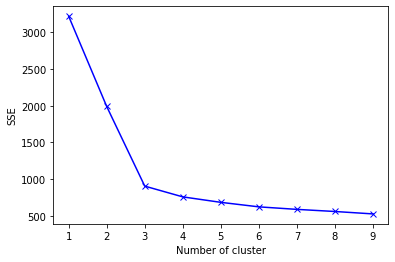

In [55]:
# step 1
sse = {} 

# step 2 - iterate for a range of Ks and fit the scaled data to the algorithm. Use inertia attribute from the clustering object and 
# store the inertia value for that k 
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000, random_state=1).fit(data_scaled)
    sse[k] = kmeans.inertia_

# step 3
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()), 'bx-')
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

- Looking at the plot, we can say that elbow point is achieved for k=3.
- We will fit the k-means again with k=3 to get the labels.

#### Question 4: 

- **From the above elbow plot, state the reason for choosing k=3 and with random_state=1(1 Mark)**
-- The greatest drop in SSE is obtained going from k=2 to k=3, beyond which there is diminishing returns when further increasing k to 4. 
- **Fit the K-means algorithms on the scaled data with number of cluster equal to 3 (2 Mark)**
- **Store the predictions as 'Labels' to the 'data_scaled_copy' and 'data' dataframes (2 Marks)**

In [56]:
kmeans = KMeans(n_clusters=3, max_iter=1000, random_state=1) #Apply the K-Means algorithm
kmeans.fit(data_scaled) #Fit the kmeans function on the scaled data

#Adding predicted labels to the original data and scaled data 
data_scaled_copy['Labels'] = kmeans.predict(data_scaled) #Save the predictions on the scaled data from K-Means
data['Labels'] = kmeans.predict(data_scaled) #Save the predictions on the scaled data from K-Means

We have generated the labels with k-means. Let us look at the various features based on the labels.

#### **Question 5: Create cluster profiles using the below summary statistics and box plots for each label (6 Marks)**

In [57]:
#Number of observations in each cluster
data.Labels.value_counts()

1    374
0    221
2     49
Name: Labels, dtype: int64

In [ ]:
#Calculating summary statistics of the original data for each label
mean = data.groupby('Labels').mean()
median = data.groupby('Labels').median()
df_kmeans = pd.concat([mean, median], axis=0)
df_kmeans.index = ['group_0 Mean', 'group_1 Mean', 'group_2 Mean', 'group_0 Median', 'group_1 Median', 'group_2 Median']
df_kmeans.T

,group_0 Mean,group_1 Mean,group_2 Mean,group_0 Median,group_1 Median,group_2 Median
Avg_Credit_Limit,12239.819005,33893.048128,140102.040816,12000.0,31500.0,145000.0
Total_Credit_Cards,2.411765,5.508021,8.775510,2.0,6.0,9.0
Total_visits_bank,0.945701,3.489305,0.591837,1.0,3.0,1.0
Total_visits_online,3.561086,0.975936,10.979592,4.0,1.0,11.0
Total_calls_made,6.891403,1.997326,1.102041,7.0,2.0,1.0


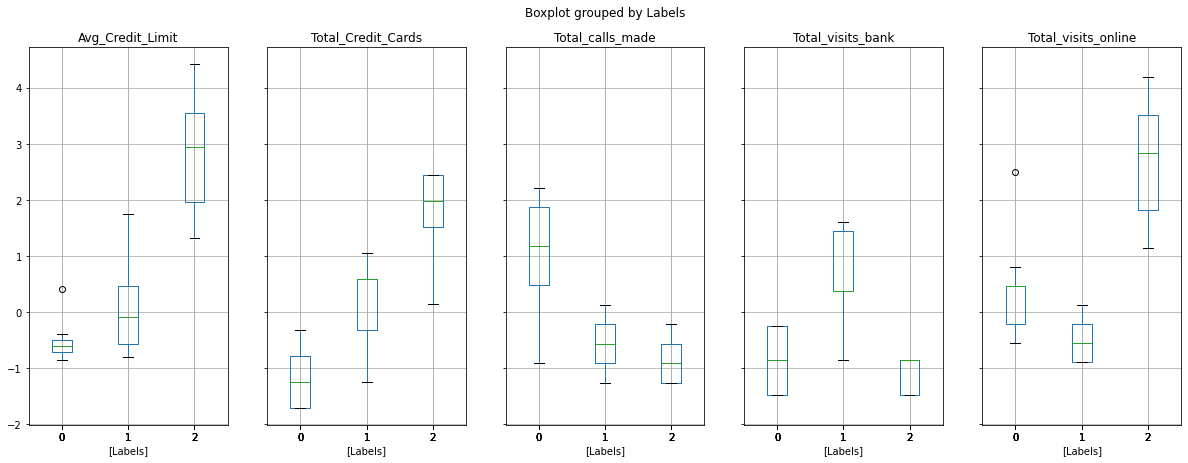

In [ ]:
#Visualizing different features w.r.t K-means labels
data_scaled_copy.boxplot(by = 'Labels', layout = (1,5),figsize=(20,7))
plt.show()

**Cluster Profiles:**
- The means and medians for scaled Avg_Credit_Limit and Total_Credit_Cards monotonically increase from cluster 0 to 1 to 2.  Groups 0 and 2 are separable based on these two variables. However, groups 0 and 1 or groups 1 and 2 are not separable based on these two variables taken individually. 
- Group 0 has the lowest range and IQR for scaled Avg_Credit_Limit, whereas Group 2 has the highest range and IQR for this variable.  
- For Total_Credit_Cards, all three groups have about the same range and IQR.  
- The mean and median for scaled Total_calls_made decrease from cluster 0 to 1 to 2.  None of the clusters are separable along this variable alone. 
- Of the three clusters, group 1 has the highest scaled Total_visits_bank, whereas the medians for groups 0 and 2 are comparable for this variable. The mean of group 1 is almost twice the mean for group 2 for this variable.  None of the groups are separable based on this variable alone.  
-  Of the three clusters, group 1 has the lowest mean and median for scaled variable Total_visits_online, followed by group 0, followed by group 2. Groups 0 and 1 have about the same range and IQR along scaled variable Total_visits_online, whereas group 2 has the greatest range and IQR for this variable.   

## Gaussian Mixture

Let's create clusters using Gaussian Mixture Models

#### Question 6: 

- **Apply the Gaussian Mixture algorithm on the scaled data with random_state=1 (2 Marks)** 
- **Create cluster profiles using the below summary statistics and box plots for each label (2 Marks)**
- **Compare the clusters from both algorithms - K-means and Gaussian Mixture (1 Mark)**

In [58]:
gmm = GaussianMixture(n_components=3, random_state=1) #Apply the Gaussian Mixture algorithm
gmm.fit(data_scaled) #Fit the gmm function on the scaled data

data_scaled_copy['GmmLabels'] = gmm.predict(data_scaled)
data['GmmLabels'] = gmm.predict(data_scaled)

In [59]:
#Number of observations in each cluster
data.GmmLabels.value_counts()

1    374
0    221
2     49
Name: GmmLabels, dtype: int64

In [60]:
#Calculating summary statistics of the original data for each label
original_features = ["Avg_Credit_Limit","Total_Credit_Cards","Total_visits_bank","Total_visits_online","Total_calls_made"]

mean = data.groupby('GmmLabels').mean()
median = data.groupby('GmmLabels').median()
df_gmm = pd.concat([mean, median], axis=0)
df_gmm.index = ['group_0 Mean', 'group_1 Mean', 'group_2 Mean', 'group_0 Median', 'group_1 Median', 'group_2 Median']
df_gmm[original_features].T

,group_0 Mean,group_1 Mean,group_2 Mean,group_0 Median,group_1 Median,group_2 Median
Avg_Credit_Limit,12239.819005,33893.048128,140102.040816,12000.0,31500.0,145000.0
Total_Credit_Cards,2.411765,5.508021,8.775510,2.0,6.0,9.0
Total_visits_bank,0.945701,3.489305,0.591837,1.0,3.0,1.0
Total_visits_online,3.561086,0.975936,10.979592,4.0,1.0,11.0
Total_calls_made,6.891403,1.997326,1.102041,7.0,2.0,1.0


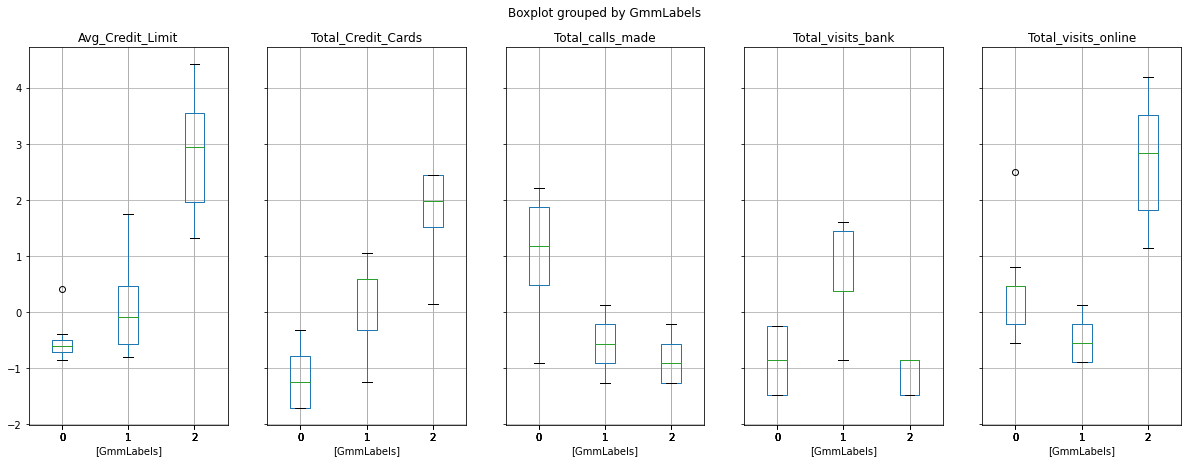

In [61]:
# plotting boxplots with the new GMM based labels

features_with_lables = ["Avg_Credit_Limit","Total_Credit_Cards","Total_visits_bank","Total_visits_online","Total_calls_made","GmmLabels"]

data_scaled_copy[features_with_lables].boxplot(by = 'GmmLabels', layout = (1,5),figsize=(20,7))
plt.show()

**Cluster Profiles:**
- The means and medians for scaled Avg_Credit_Limit and Total_Credit_Cards monotonically increase from cluster 0 to 1 to 2.  Groups 0 and 2 are separable based on these two variables. However, groups 0 and 1 or groups 1 and 2 are not separable based on these two variables taken individually. 
- Group 0 has the lowest range and IQR for scaled Avg_Credit_Limit, whereas Group 2 has the highest range and IQR for this variable.  
- For Total_Credit_Cards, all three groups have about the same range and IQR.  
- The mean and median for scaled Total_calls_made decrease from cluster 0 to 1 to 2.  None of the clusters are separable along this variable alone. 
- Of the three clusters, group 1 has the highest scaled Total_visits_bank, whereas the medians for groups 0 and 2 are comparable for this variable. The mean of group 1 is almost twice the mean for group 2 for this variable.  None of the groups are separable based on this variable alone.  
-  Of the three clusters, group 1 has the lowest mean and median for scaled variable Total_visits_online, followed by group 0, followed by group 2. Groups 0 and 1 have about the same range and IQR along scaled variable Total_visits_online, whereas group 2 has the greatest range and IQR for this variable.
  

**Comparing Clusters:**
- The cluster profiles using GMM are very similar (identical) to the cluster profiles obtained above from K-Means, for the respective scaled variables, when using the same number of clusters.

## K-Medoids

#### Question 7: 

- **Apply the K-Mediods on the scaled data with random_state=1 (2 Marks)** 
- **Create cluster profiles using the below summary statistics and box plots for each label (2 Marks)**
- **Compare the clusters from both algorithms - K-Means and K-Medoids (2 Marks)**

In [62]:
kmedo = KMedoids(n_clusters=3, random_state=1) #Apply the K-Medoids algorithm
kmedo.fit(data_scaled) #Fit the kmedo function on the scaled data

data_scaled_copy['kmedoLabels'] = kmedo.predict(data_scaled)
data['kmedoLabels'] = kmedo.predict(data_scaled)

In [63]:
#Number of observations in each cluster
data.kmedoLabels.value_counts()

2    289
0    222
1    133
Name: kmedoLabels, dtype: int64

In [64]:
#Calculating summary statistics of the original data for each label
mean = data.groupby('kmedoLabels').mean()
median = data.groupby('kmedoLabels').median()
df_kmedoids = pd.concat([mean, median], axis=0)
df_kmedoids.index = ['group_0 Mean', 'group_1 Mean', 'group_2 Mean', 'group_0 Median', 'group_1 Median', 'group_2 Median']
df_kmedoids[original_features].T

,group_0 Mean,group_1 Mean,group_2 Mean,group_0 Median,group_1 Median,group_2 Median
Avg_Credit_Limit,12216.216216,85052.631579,28449.826990,12000.0,68000.0,20000.0
Total_Credit_Cards,2.423423,7.030075,5.363322,2.0,7.0,5.0
Total_visits_bank,0.950450,1.691729,3.830450,1.0,2.0,4.0
Total_visits_online,3.554054,4.639098,0.982699,4.0,2.0,1.0
Total_calls_made,6.878378,1.969925,1.851211,7.0,2.0,2.0


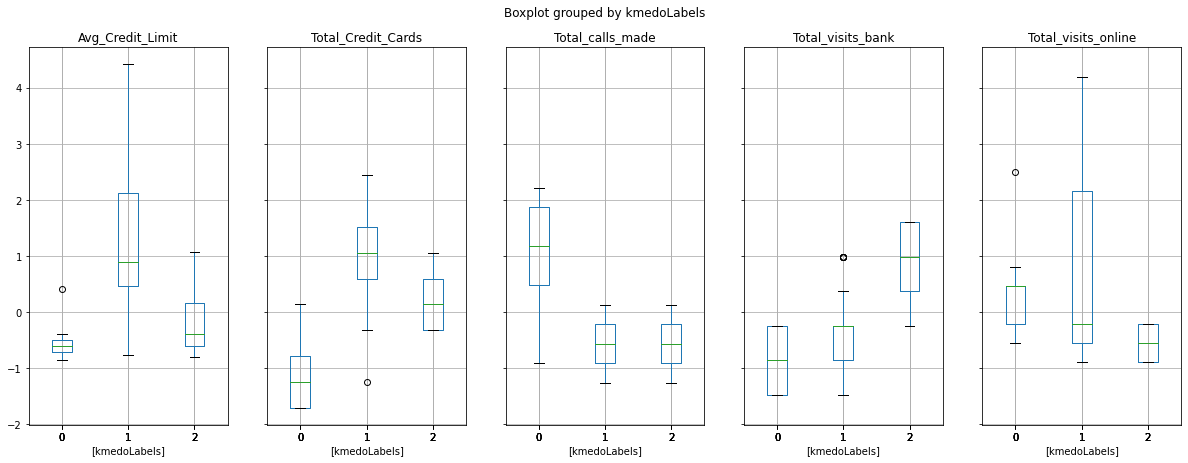

In [ ]:
#plotting boxplots with the new K-Medoids based labels

features_with_lables = ["Avg_Credit_Limit",	"Total_Credit_Cards","Total_visits_bank","Total_visits_online","Total_calls_made","kmedoLabels"]

data_scaled_copy[features_with_lables].boxplot(by = 'kmedoLabels', layout = (1,5),figsize=(20,7))
plt.show()

Let's compare the clusters from K-Means and K-Medoids 

In [66]:
mean = data.groupby('Labels').mean()
median = data.groupby('Labels').median()
df_kmeans = pd.concat([mean, median], axis=0)
df_kmeans.index = ['group_0 Mean', 'group_1 Mean', 'group_2 Mean', 'group_0 Median', 'group_1 Median', 'group_2 Median']
df_kmeans.T

comparison = pd.concat([df_kmedoids, df_kmeans], axis=1)[original_features]
comparison

,Avg_Credit_Limit,Avg_Credit_Limit,Total_Credit_Cards,Total_Credit_Cards,Total_visits_bank,Total_visits_bank,Total_visits_online,Total_visits_online,Total_calls_made,Total_calls_made
group_0 Mean,12216.216216,12239.819005,2.423423,2.411765,0.950450,0.945701,3.554054,3.561086,6.878378,6.891403
group_1 Mean,85052.631579,33893.048128,7.030075,5.508021,1.691729,3.489305,4.639098,0.975936,1.969925,1.997326
group_2 Mean,28449.826990,140102.040816,5.363322,8.775510,3.830450,0.591837,0.982699,10.979592,1.851211,1.102041
group_0 Median,12000.000000,12000.000000,2.000000,2.000000,1.000000,1.000000,4.000000,4.000000,7.000000,7.000000
group_1 Median,68000.000000,31500.000000,7.000000,6.000000,2.000000,3.000000,2.000000,1.000000,2.000000,2.000000
group_2 Median,20000.000000,145000.000000,5.000000,9.000000,4.000000,1.000000,1.000000,11.000000,2.000000,1.000000


**Cluster Profiles:**
- Profile statistics (mean and median) for Group 0 for each of the scaled variables are almost identical to those obtained for K-Means and GMM clustering above.  
- The mean and median for total visits bank increases monotonically from group 0 to group 1 to group 2, using K-Medoids. 
- Conversely, the median for total visits online decreases monotonically from group 0 to group 1 to group 2, using K-Medoids.
- For variables average credit limit and total visits online, the group range and IQR has increased significantly using K-Medoids.
- None of the groups are separable using K-Medoids using any of the individual scaled variables.

**Comparing Clusters:**
- Group 0 for any of the scaled variables is not significantly impacted by the choice of K-Means or K-Medoids.  
- Group 1 mean has increased for Average_Credit_Limit, Total_Credit_Cards, and Total_visits_online, whereas group 2 mean has decreased for these three variables using K-Medoids. Thus, the separability between groups has diminished using K-Medoids. 
- Group 1 mean has conversely decreased for Total_visits_bank, whereas Group 2 mean has increased for this variable, using K-Medoids.     